In [1]:
from torchcnnbuilder.models import ForecasterBase
from torch import nn
import torch
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader
import mlflow
from torchsummary import summary
from pathlib import Path
from torchmetrics.image import StructuralSimilarityIndexMeasure

class ModelArtic(nn.Module):
    def __init__(self, c_in, c_out, num_layers, batch_norm = False):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.batch_norm = batch_norm
        self.c_in = c_in
        self.c_out = c_out
        self.num_layers = num_layers
        if batch_norm:
            self.bn = nn.BatchNorm2d(4)
        self.model = ForecasterBase(input_size=[432, 432],
                       in_time_points=self.c_in,
                       out_time_points=self.c_out,
                       n_layers=self.num_layers)    
    
    def forward(self, x):
        if self.batch_norm:
            x = self.bn(x)
        x = self.model(x)
        return x
    
    def train(self, dataloader, current_epoch, lr = 1e-5):
        self.model.train()
        self.model = self.model.to(self.device)
        optimizer = torch.optim.AdamW(lr=lr, params=self.model.parameters())
        loss_sum = 0.0
        count_objects = len(dataloader)

        for index, (x, y) in tqdm(enumerate(dataloader)):
            optimizer.zero_grad()
            x = x.to(self.device).to(torch.float32)
            y = y.to(self.device).to(torch.float32)
            logits = self.model(x)
            loss = F.l1_loss(logits, y)
            loss.backward()
            optimizer.step()
            global_step = current_epoch * len(dataloader) + index 
            mlflow.log_metric('MAE loss per step', loss.item(), step=global_step)
            loss_sum += loss   
        torch.cuda.empty_cache() 
        return loss_sum / count_objects
    
    def evaluate(self, dataloader):
        self.model = self.model.to(self.device)
        self.model.eval()
        metric = 0

        with torch.no_grad():
            for data in tqdm(dataloader):
                x, y = data
                x  = x.to(self.device).to(torch.float32)
                y = y.to(self.device).to(torch.float32)
                preds = self.model(x)
                er = F.l1_loss(preds, y).item()
                metric += er
            torch.cuda.empty_cache()
        return metric / len(dataloader)
    
    def train_loop(self, dataloader_train:DataLoader, dataloader_eval:DataLoader, epochs: int = 100):
        mlflow.set_experiment(experiment_name='model trained per week, min/max scaler')
        with mlflow.start_run() as run:
            params = {
                'epochs':epochs,
                'learning_rate': 1e-5,
                'batch_size':32,
                'loss_function': F.l1_loss,
                'metric_function': F.l1_loss,
                'optimizer': 'AdamW'
            }

        mlflow.log_params(params)
    
        with open('model_summary.txt', 'w') as f:
            f.write(str(summary))
        mlflow.log_artifact('model_summary.txt')

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}")
            loss_epoch = self.train(dataloader_train, epoch)
            mlflow.log_metric('MAE avareage on epoch', loss_epoch, step=epoch)
            val_metric = self.evaluate(dataloader_eval)
            mlflow.log_metric('MAE on validation after epoch', val_metric, step=epoch)
            print(f'Current metric on validation is {val_metric}')
    
        mlflow.pytorch.log_model(model, "model")

    
    def calc_psnr(self, pred:torch.Tensor, label:torch.Tensor, scaled:bool = True):
        if scaled:
            max_val = 1
        else:
            max_val = 100
        mse = F.mse_loss(pred, label)
        return 20*torch.log10(max_val / torch.sqrt(mse)).item()

    
    def load(self, path:str):
        state_dict = torch.load(path)
        new_state_dict = {}
        for k, v in state_dict.items():
            if k.startswith('model.'):
                new_state_dict[k[6:]] = v 
            else:
                new_state_dict[k] = v
        self.model.load_state_dict(new_state_dict)

    def save(self, path:str, model_name:str = None):
        if model_name is None:
            model_name = Path('model.pt')
        else:
            model_name = Path(model_name)
        path = Path(path)
        self.model.save(self.state_dict(), path / Path('model.pth'))

    def test(self, dataloader_test):
        ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(self.device)
        metrics = dict()
        len_images = 0
        mae_loss_count = 0
        psnr_loss_count = 0
        ssim_loss_count = 0

        self.model.eval()
        self.model = self.model.to(self.device)
        
        with torch.no_grad():
            for data in tqdm(dataloader_test):
                torch.cuda.empty_cache()
                x, y = data
                x = x.to(self.device).to(torch.float32)
                y = y.to(self.device)
                preds = self.model(x)

                preds, y = preds.squeeze(), y.squeeze()
                len_images = preds.shape[0]

                for index in tqdm(range(preds.shape[0])):
                    mae_loss_count += F.l1_loss(preds[index], y[index]).item()
                    psnr_loss_count += self.calc_psnr(pred=preds[index], label= y[index])  
                    ssim_loss_count += ssim(preds[index].unsqueeze(0).unsqueeze(0), y[index].unsqueeze(0).unsqueeze(0))
                mae_loss_count /= len_images
                psnr_loss_count /= len_images
                ssim_loss_count /= len_images
                if len(metrics.keys()) == 0:
                    metrics['mae'] = [mae_loss_count]
                    metrics['psnr'] = [psnr_loss_count]
                    metrics['ssim'] = [ssim_loss_count]
                    mae_loss_count = 0
                    psnr_loss_count = 0
                else:
                    metrics['mae'].append(mae_loss_count)
                    metrics['psnr'].append(psnr_loss_count)
                    metrics['ssim'].append(ssim_loss_count)
                    mae_loss_count = 0
                    psnr_loss_count = 0
                torch.cuda.empty_cache()
        
        if len(metrics['mae']) < 2:    
            print('-'*10)
            print(f'MAE loss is {metrics['mae'][0]}')
            print('-'*10)
            print(f'SSIM loss is {metrics['ssim'][0]}')
            print('-' * 10)
            print(f'PSNR metric is {metrics['psnr'][0]}')

    def prediction(self, x:torch.Tensor):
        self.model.eval()
        self.model = self.model.to(self.device)
        x = x.to(self.device).to(torch.float32)
        with torch.no_grad():
            return self.model(x)
        
        

In [2]:
from models.baseline import ModelArtic
from data.data_prepare import MakeTimeSeriesPerWeek
from data.dataset_arctic import IceDataset
from torch.utils.data import DataLoader

temp_data = MakeTimeSeriesPerWeek(r'D:\Arctic_project\dataset\osisaf')
temp_data.load()
dataset_train = IceDataset(temp_data.x_train, temp_data.y_train)
dataset_val = IceDataset(temp_data.x_val, temp_data.y_val)
dataset_test = IceDataset(temp_data.x_test, temp_data.y_test)

dataloader_train = DataLoader(dataset_train, batch_size=8)
dataloader_val = DataLoader(dataset_val, batch_size=8)
dataloader_test = DataLoader(dataset_test, batch_size=8)

100%|██████████| 1/1 [00:00<00:00, 56.65it/s]


In [3]:
model = ModelArtic(c_in=48, c_out=24, num_layers=5)
# model.train_loop(dataloader_train=dataloader_train, dataloader_eval=dataloader_val)

model.load(r'D:\Arctic_project\model_weights\bets_model.pth')
model.test(dataloader_test=dataloader_test)

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

----------
MAE loss is 0.029474877945782043
----------
SSIM loss is 0.857512354850769
----------
PSNR metric is 19.39797950984398


In [16]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from pathlib import Path

class Visualize:
    def __init__(self, num_weeks:int = 5):
        self.num_weeks = num_weeks

    def visualize(self, pred, label, start = 0,):
        if pred.device == 'cpu':
            pred = pred.to(torch.device('cpu'))
            label = label.to(torch.device('cpu'))
        pred = pred.cpu().numpy()
        label = label.cpu().numpy()
        mask = self._get_mask()
        fig, axes = plt.subplots(2, 5, figsize = (17, 8))
        fig.text(0.5, 0.93, 'Ground truth', fontsize = 16, ha='center', va='center')
        fig.text(0.5, 0.5, 'Model predictions', fontsize = 16)
        for i in range(start, self.num_weeks + start):
            axes[0, i].imshow(mask - label[i], cmap='Blues')
            axes[0, i].set_xticks([])
            axes[0, i].set_yticks([])
            for spine in axes[0, i].spines.values():
                spine.set_visible(False)
            axes[0, i].set_title(f'week is month {i//4 + 1}, year is 2020')
            axes[0, i].set_xlabel(f'Mae is {F.l1_loss(torch.tensor(pred[i]), 
                                                      torch.tensor(label[i]))}')
            
            axes[1, i].imshow(mask - pred[i], cmap='Blues')
            axes[1, i].set_xticks([])
            axes[1, i].set_yticks([])
            for spine in axes[1, i].spines.values():
                spine.set_visible(False)
            axes[1, i].set_title(f'week is month {i//4 + 1}, year is 2020')
            axes[1, i].set_xlabel(f'Mae is {F.l1_loss(torch.tensor(pred[i]),
                                                       torch.tensor(label[i])).item()}')
        plt.subplots_adjust(top=0.9, hspace=0.5)
        plt.show()

    def _get_mask(self, path:str = r'D:\Arctic_project\dataset\land_mask.npy'):
        return np.load(Path(path))

In [17]:
x = temp_data.x_test[0]

res = model.prediction(x)

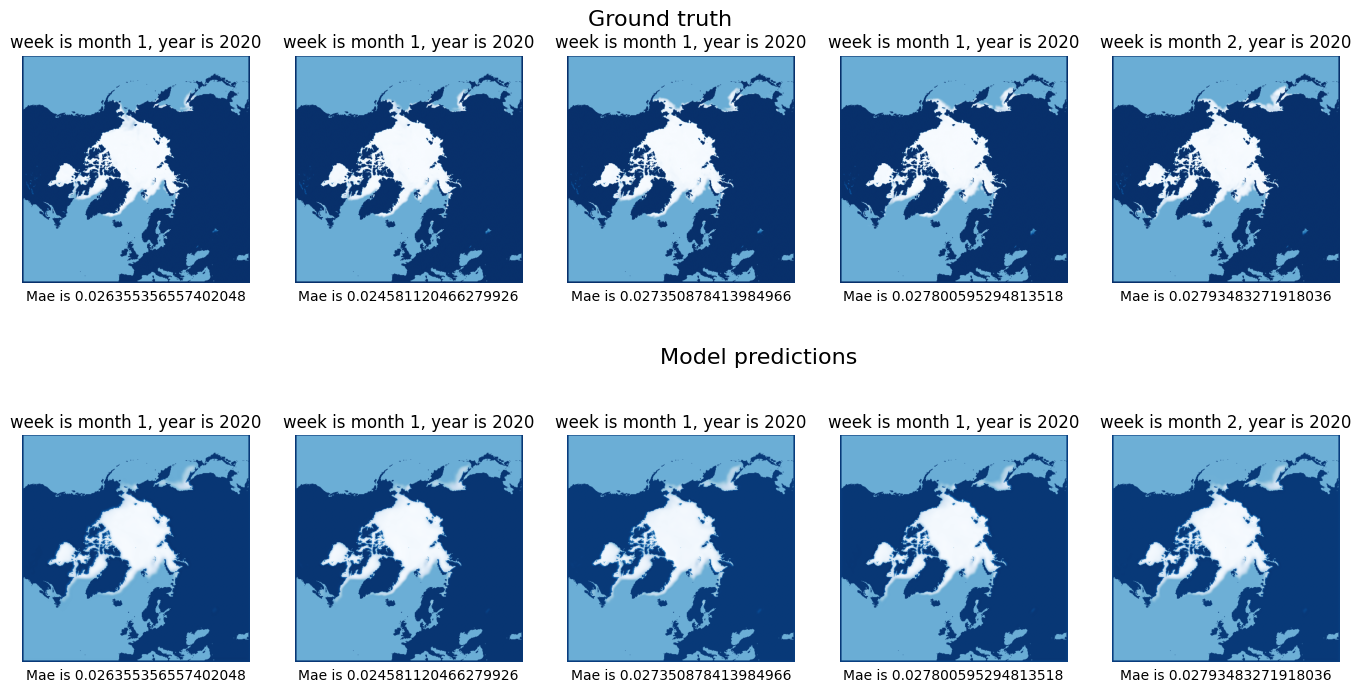

In [18]:
vis = Visualize()
vis.visualize(res, temp_data.y_test[0])

In [10]:
res.shape

torch.Size([24, 432, 432])

In [11]:
res.max()

tensor(1.1283, device='cuda:0')

In [ ]:
m = vis.get_mask()

In [ ]:
m.shape

(432, 432)

In [12]:
y_t = temp_data.y_test[0]

In [13]:
y_t.shape

torch.Size([24, 432, 432])

In [15]:
y_t.max()

tensor(1., dtype=torch.float64)

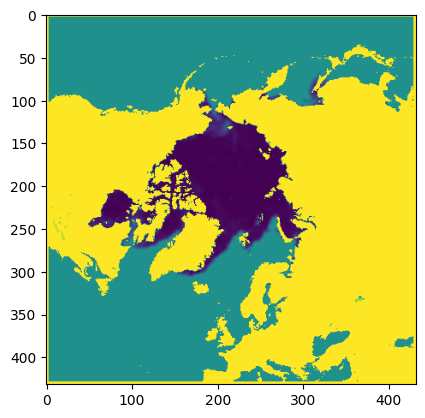

In [ ]:
plt.imshow(mask - y_t.numpy())